In [ ]:
import torch

# Check if MPS is available
print("MPS available:", torch.backends.mps.is_available())

# Check if MPS is built
print("MPS built:", torch.backends.mps.is_built())

# Check current device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Current device:", device)

<h4> # Import all modules

In [ ]:
from data_loader import load_images, split_data
from preprocessing import preprocess_all_images,expand_channels_for_split,get_augmentation_transform,show_random_clahe_images_per_label,preprocess_image_cv2
from dataset import MergedImagesDataset
from model import get_resnet18_model,get_resnet18_model_layer_added, get_mobilenetv2_model,get_mobilenetv2_model_layer_added,get_efficientnetb0_model_layer_added,get_efficientnetv2_s_model_layer_added
from train import train_model_with_val
from evaluate import evaluate_model, plot_training_curves
from utils import EarlyStoppingWithLR, save_best_model_state
from grad_cam import show_grad_cam_for_random_images_per_label

import torch

<h4> # 1. Load images and labels <h4>

In [ ]:
images, labels = load_images()
#labels = ['Good' if l == 'Good' else 'Defective' for l in labels] ## Binary mapping


<h4> # 2. Preprocess images <h4>

In [ ]:
merged_images, sobel_images, canny_images, clahe_images = preprocess_all_images(images)

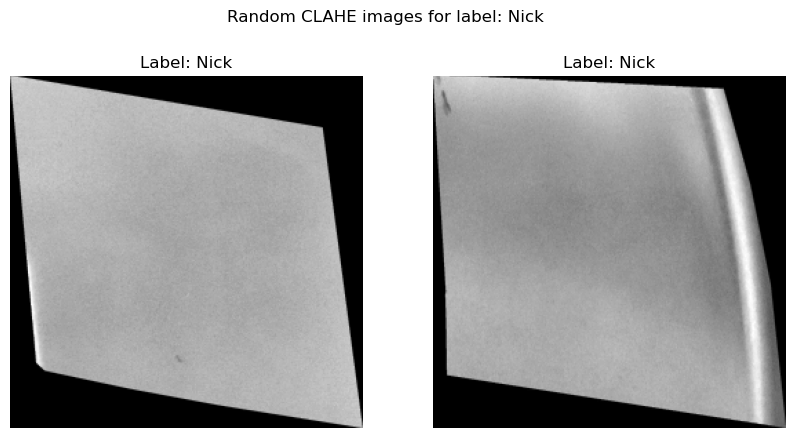

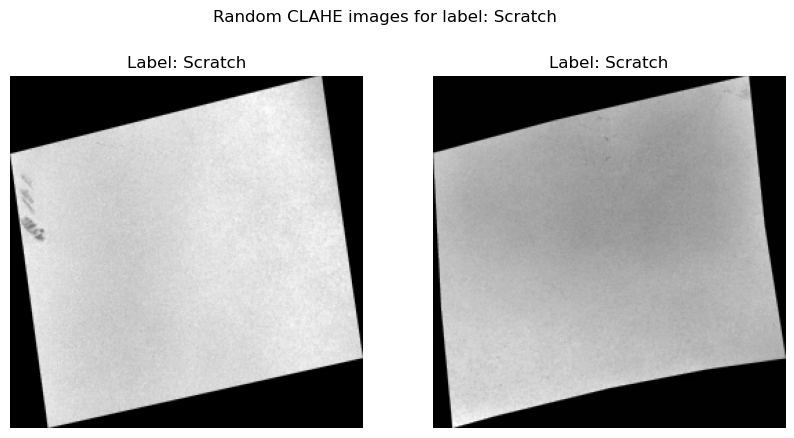

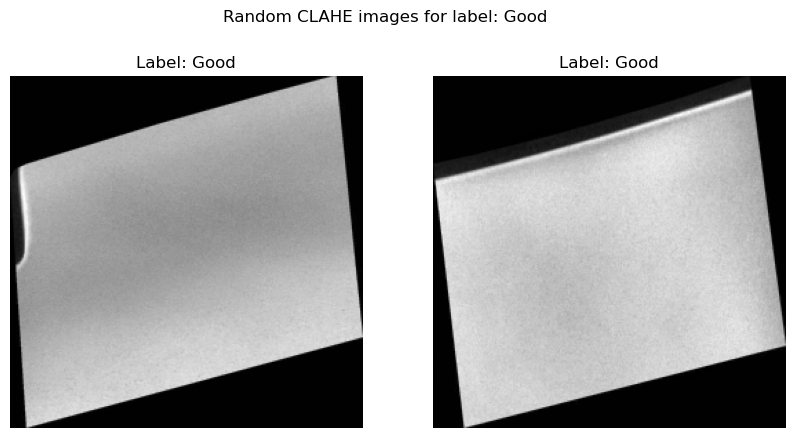

In [21]:
show_random_clahe_images_per_label(clahe_images, labels, n_per_label=2)

<h4> # 3. Split data. <h4>

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(list(clahe_images),labels)

<h4> # 4. Expand channels for compatibility with pretrained models <h4>

In [ ]:
x_train_exp, x_val_exp, x_test_exp = expand_channels_for_split(x_train, x_val, x_test)

In [ ]:
print(len(x_test_exp))

<h4> # 5. Prepare label mapping <h4>

In [ ]:
unique_labels = sorted(set(labels))
label_to_idx = {label: idx for idx , label in enumerate(unique_labels)}

<h4> # 6. Data augmentation <h4>

In [ ]:
transform = get_augmentation_transform()

<h4> # 7. Create datasets and dataloaders

In [ ]:
train_dataset = MergedImagesDataset(x_train_exp, y_train, label_to_idx, transform=transform)
val_dataset = MergedImagesDataset(x_val_exp, y_val, label_to_idx)
test_dataset = MergedImagesDataset(x_test_exp, y_test, label_to_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


<h4> # 8. Model, loss, optimizer, scheduler <h4>

In [ ]:
device = torch.device('mps')
num_classes = len(unique_labels)
model = get_efficientnetv2_s_model_layer_added(num_classes, freeze=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-5)
early_stopper = EarlyStoppingWithLR(optimizer, patience=4, lr_patience=2, factor=0.7)

<h4> # 9. Train <h4>


In [ ]:
loss_history, acc_history, val_loss_history, val_acc_history = train_model_with_val(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, early_stopper=early_stopper
)
save_best_model_state(early_stopper.best_state, "best_model_Binary.pth")

<h4> # 10. Evaluate <h4>

In [ ]:
plot_training_curves(loss_history, acc_history, val_loss_history, val_acc_history)
evaluate_model(model, test_loader, device, unique_labels)

<h4> # 11 Grad-Cam <h4>

In [ ]:
# Grad-CAM visualization for 2 random images per label (using numpy arrays)
num_classes = len(unique_labels)  # or the correct number for your task
model = get_efficientnetv2_s_model_layer_added(num_classes, freeze=False)
model.load_state_dict(torch.load("models/best_model.pth", map_location=device))
model.to(device)
model.eval()
show_grad_cam_for_random_images_per_label(model, test_dataset, labels, label_to_idx, device, n_per_label=2)

# Debug model predictions for Scratch images in the test set only if debug is True
debug = False
if debug:
    import torch.nn.functional as F

    # Find indices of Nick images in the test set
    nick_indices_test = [i for i, l in enumerate(y_test) if l == "Nick"]

    for idx in nick_indices_test:  # Check all Nick images in test set
        img_array = x_test_exp[idx]
        # Preprocess as in grad-cam
        from torchvision import transforms
        input_tensor = transforms.Compose([
            transforms.ToTensor(),
        ])(img_array).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            pred_class = torch.argmax(probs).item()
            pred_label = unique_labels[pred_class]
            print(f"Test idx: {idx}, True label: Scratch, Predicted class: {pred_class} ({pred_label}), Probabilities: {probs.cpu().numpy()}")

    evaluate_model(model, test_loader, device, unique_labels)